# Prepare

In [ ]:
!pip install -U efficientnet
!pip install tensorflow-addons

     |████████████████████████████████| 50 kB 6.9 MB/s 
     |████████████████████████████████| 1.1 MB 12.1 MB/s 


In [ ]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import cv2

import efficientnet
import efficientnet.tfkeras as efn

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow.keras as keras
from tensorflow.data import Dataset

import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

In [ ]:
def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    for case_name in os.listdir(data_dir):
        current_path = os.path.join(data_dir, case_name)
        if os.path.isdir(current_path):
            # get image path
            img_path_list.extend(glob(os.path.join(current_path, 'image', '*.jpg')))
            img_path_list.extend(glob(os.path.join(current_path, 'image', '*.png')))
            
            # get label
            label_df = pd.read_csv(current_path+'/label.csv')
            label_list.extend(label_df['leaf_weight'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    # get image path
    img_path_list = glob(os.path.join(data_dir, 'image', '*.jpg'))
    img_path_list.extend(glob(os.path.join(data_dir, 'image', '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
    return img_path_list

In [ ]:
def load_img_numpy(img_dir, target_size) :
    img = cv2.imread(img_dir)
    img = cv2.resize(img, dsize=target_size)
    img = img.astype(np.float32) / 255.0 # normalize 
    return img

In [ ]:
def create_dataset(img_dir, label, target_size, batch_size=None) :    
    img = [] # 원본이미지
    
    ## 최적화가 필요한 부분
    for i in img_dir:
        image = load_img_numpy(i, target_size)
        img.append(image)
        
    x = Dataset.from_tensor_slices(img)
    y = Dataset.from_tensor_slices(label)
    dataset = Dataset.zip((x, y))
    
    if batch_size is not None:
        dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
   
    return dataset

In [ ]:
def load_test_img_numpy(img_dir, target_size) :
    img = cv2.imread(img_dir)
    img = cv2.resize(img, dsize=target_size)
    img = img.astype(np.float32) / 255.0
    return img

def create_test_dataset(img_dir, target_size, batch_size=None) :
    file_name = [x.split('/')[-1][:-4] for x in img_dir]
    x_img = []

    for i in tqdm(img_dir,
                total=len(img_dir),
                position=0,
                leave=True):
        img = load_test_img_numpy(i, target_size)
        x_img.append(img)

    dataset = Dataset.from_tensor_slices(x_img)
    
    if batch_size is not None :
        dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
       
    return dataset, file_name

# Load Data Set

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 8
LEARNING_RATE = 5e-5

all_img_path, all_label = get_train_data('/content/drive/MyDrive/AI_proj/data/train')
test_img_path = get_test_data('/content/drive/MyDrive/AI_proj/data/test')

NameError: ignored

In [ ]:
# Train : Validation = 0.8 : 0.2 Split
train_len = int(len(all_img_path)*0.8)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

vali_img_path = all_img_path[train_len:]
vali_label = all_label[train_len:]

In [ ]:
train_dataset = create_dataset(train_img_path, train_label, (IMAGE_SIZE, IMAGE_SIZE), BATCH_SIZE)
valid_dataset = create_dataset(vali_img_path, vali_label, (IMAGE_SIZE, IMAGE_SIZE), BATCH_SIZE )

In [ ]:
train_dataset

<RepeatDataset element_spec=(TensorSpec(shape=(8, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8,), dtype=tf.float32, name=None))>

In [ ]:
valid_dataset

<RepeatDataset element_spec=(TensorSpec(shape=(8, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8,), dtype=tf.float32, name=None))>

# EfficientNetB4 Model

In [ ]:
base_model = efn.EfficientNetB4(
    weights='imagenet',
    include_top = False,
    input_shape = (IMAGE_SIZE,IMAGE_SIZE) + (3,)
)
base_model.summary()

In [ ]:
from tensorflow.keras.regularizers import *

LAMBDA_VAL = 0.001

base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D()) # Flatten??
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu', kernel_regularizer=L2(l2=LAMBDA_VAL)))
model.add(Dense(1, activation='linear', kernel_regularizer=L2(l2=LAMBDA_VAL)))

# Early Stopping
es = EarlyStopping(monitor='val_loss',
                   mode='auto',
                   patience=5,
                   verbose=1)

# # Checkpoint
# model_checkpoint = './{epoch:06d}-{val_acc:0.6f}-{acc:0.6f}.ckpt'

# checkpointer = ModelCheckpoint(
#     filepath=model_checkpoint,
#     verbose=1,
#     period=2,
#     save_best_weights=True,
#     mode='auto',
#     monitor='val_acc'
# )



In [ ]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mse',
              metrics=['mae'])


EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    # callbacks=[es, checkpointer],
                    verbose=1)

model.save('./pretrained_model.h5')

Epoch 1/30
159/159 [==============================] - 39s 176ms/step - loss: 17154.9375 - mae: 81.5684 - val_loss: 14598.2100 - val_mae: 65.7324
Epoch 2/30
159/159 [==============================] - 25s 157ms/step - loss: 15816.6025 - mae: 77.6333 - val_loss: 13240.1299 - val_mae: 60.9907
Epoch 3/30
159/159 [==============================] - 25s 156ms/step - loss: 13988.5547 - mae: 74.7799 - val_loss: 11920.6123 - val_mae: 58.6001
Epoch 4/30
159/159 [==============================] - 25s 158ms/step - loss: 12477.6543 - mae: 74.3859 - val_loss: 11062.2480 - val_mae: 63.8093
Epoch 5/30
159/159 [==============================] - 25s 156ms/step - loss: 11488.3486 - mae: 75.4274 - val_loss: 10580.5547 - val_mae: 69.4379
Epoch 6/30
159/159 [==============================] - 25s 156ms/step - loss: 10883.0264 - mae: 76.4956 - val_loss: 10230.1416 - val_mae: 72.4872
Epoch 7/30
159/159 [==============================] - 25s 156ms/step - loss: 10500.6514 - mae: 77.0331 - val_loss: 9911.1270 - val

Text(0.5, 1.0, 'Training and Validation MAE')

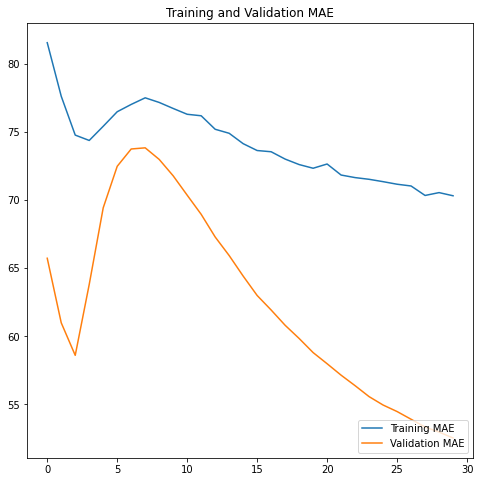

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

### finetune

In [ ]:
base_model.trainable=False
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  467


In [ ]:
fine_tune_at= 400

for i, layer in enumerate(base_model.layers[:fine_tune_at]):
    if 'bn' not in layer.name :
        layer.trainable = True

In [ ]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE/10),
              loss='mse',
              metrics=['mae'])

In [ ]:
FINE_TUNE_EPOCHS = 30 
history = model.fit(train_dataset, epochs=FINE_TUNE_EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    # callbacks=[es, checkpointer],
                    verbose=1)

model.save('./fine_tuned_model.h5')

Epoch 1/30
159/159 [==============================] - 42s 178ms/step - loss: 8684.0322 - mae: 70.4747 - val_loss: 5198.6055 - val_mae: 52.4061
Epoch 2/30
159/159 [==============================] - 25s 158ms/step - loss: 8784.4805 - mae: 71.0309 - val_loss: 5192.1611 - val_mae: 52.3312
Epoch 3/30
159/159 [==============================] - 25s 157ms/step - loss: 8695.8203 - mae: 70.6680 - val_loss: 5184.5757 - val_mae: 52.2562
Epoch 4/30
159/159 [==============================] - 25s 156ms/step - loss: 8684.8564 - mae: 70.4786 - val_loss: 5178.7378 - val_mae: 52.2221
Epoch 5/30
159/159 [==============================] - 25s 157ms/step - loss: 8650.3691 - mae: 70.4337 - val_loss: 5170.6318 - val_mae: 52.1369
Epoch 6/30
159/159 [==============================] - 25s 158ms/step - loss: 8613.0312 - mae: 70.2813 - val_loss: 5163.9736 - val_mae: 52.0726
Epoch 7/30
159/159 [==============================] - 25s 157ms/step - loss: 8725.8105 - mae: 70.5877 - val_loss: 5157.3555 - val_mae: 52.0171

Text(0.5, 1.0, 'Training and Validation MAE')

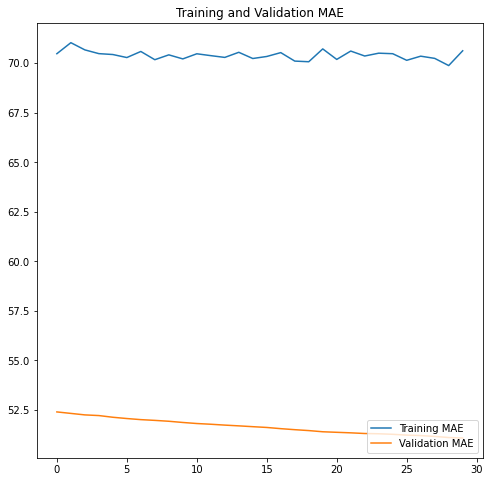

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

In [ ]:
history = model.fit(train_dataset, epochs=30,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    # callbacks=[es, checkpointer],
                    verbose=1)

model.save('./fine_tuned_model_continue.h5')

Epoch 1/30
159/159 [==============================] - 26s 162ms/step - loss: 8560.0059 - mae: 69.5549 - val_loss: 5024.8877 - val_mae: 51.0577
Epoch 2/30
159/159 [==============================] - 25s 156ms/step - loss: 8573.9717 - mae: 69.9411 - val_loss: 5018.1982 - val_mae: 51.0048
Epoch 3/30
159/159 [==============================] - 25s 156ms/step - loss: 8690.5059 - mae: 70.2387 - val_loss: 5013.3779 - val_mae: 50.9663
Epoch 4/30
159/159 [==============================] - 25s 155ms/step - loss: 8733.4219 - mae: 70.4491 - val_loss: 5008.3735 - val_mae: 50.9118
Epoch 5/30
159/159 [==============================] - 25s 154ms/step - loss: 8758.2285 - mae: 70.7246 - val_loss: 5005.3262 - val_mae: 50.8979
Epoch 6/30
159/159 [==============================] - 25s 155ms/step - loss: 8572.8262 - mae: 69.8821 - val_loss: 5001.2075 - val_mae: 50.8868
Epoch 7/30
159/159 [==============================] - 25s 156ms/step - loss: 8847.2207 - mae: 71.1327 - val_loss: 4997.5640 - val_mae: 50.8565

---
## 규제없는 모델 
&
loss = mae

In [ ]:
base_model.trainable = False
model2 = Sequential()
model2.add(base_model)
model2.add(GlobalAveragePooling2D())
model2.add(Dropout(0.3))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='linear'))

checkpoint_filepath = './no_regul_pretrain_best_model.h5'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    verbose=1
)

model2.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

In [ ]:
history2 = model2.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/30
159/159 [==============================] - ETA: 0s - loss: 82.1743 - mae: 82.1743
Epoch 1: val_mae improved from inf to 66.71297, saving model to ./no_regul_pretrain_best_model.h5
159/159 [==============================] - 42s 180ms/step - loss: 82.1743 - mae: 82.1743 - val_loss: 66.7130 - val_mae: 66.7130
Epoch 2/30
159/159 [==============================] - ETA: 0s - loss: 78.8832 - mae: 78.8832
Epoch 2: val_mae improved from 66.71297 to 63.69839, saving model to ./no_regul_pretrain_best_model.h5
159/159 [==============================] - 26s 162ms/step - loss: 78.8832 - mae: 78.8832 - val_loss: 63.6984 - val_mae: 63.6984
Epoch 3/30
159/159 [==============================] - ETA: 0s - loss: 76.7974 - mae: 76.7974
Epoch 3: val_mae improved from 63.69839 to 61.52740, saving model to ./no_regul_pretrain_best_model.h5
159/159 [==============================] - 26s 162ms/step - loss: 76.7974 - mae: 76.7974 - val_loss: 61.5274 - val_mae: 61.5274
Epoch 4/30
159/159 [=============

Text(0.5, 1.0, 'Training and Validation MAE')

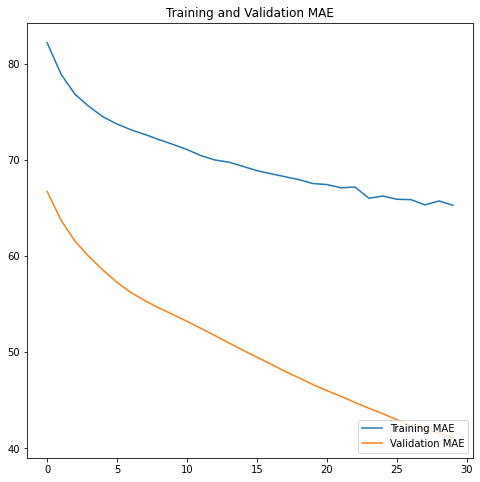

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history2.history['mae'], label='Training MAE')
plt.plot(history2.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

### finetune

In [ ]:
for i, layer in enumerate(base_model.layers[:fine_tune_at]):
    if 'bn' not in layer.name :
        layer.trainable = True

In [ ]:
model2.compile(optimizer=Adam(learning_rate=LEARNING_RATE/10),
              loss='mae',
              metrics=['mae'])

checkpoint_filepath = './no_regul_finetune_best_model.h5'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    verbose=1
)

history2 = model2.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

model2.save('./by_chance_noregul_finetunemoedl.h5')

Epoch 1/30
159/159 [==============================] - ETA: 0s - loss: 65.4098 - mae: 65.4098
Epoch 1: val_mae improved from inf to 41.02547, saving model to ./no_regul_finetune_best_model.h5
159/159 [==============================] - 40s 179ms/step - loss: 65.4098 - mae: 65.4098 - val_loss: 41.0255 - val_mae: 41.0255
Epoch 2/30
159/159 [==============================] - ETA: 0s - loss: 64.6874 - mae: 64.6874
Epoch 2: val_mae improved from 41.02547 to 40.97935, saving model to ./no_regul_finetune_best_model.h5
159/159 [==============================] - 25s 161ms/step - loss: 64.6874 - mae: 64.6874 - val_loss: 40.9794 - val_mae: 40.9794
Epoch 3/30
159/159 [==============================] - ETA: 0s - loss: 65.0135 - mae: 65.0135
Epoch 3: val_mae improved from 40.97935 to 40.93165, saving model to ./no_regul_finetune_best_model.h5
159/159 [==============================] - 25s 160ms/step - loss: 65.0135 - mae: 65.0135 - val_loss: 40.9316 - val_mae: 40.9316
Epoch 4/30
159/159 [=============

Text(0.5, 1.0, 'Training and Validation MAE')

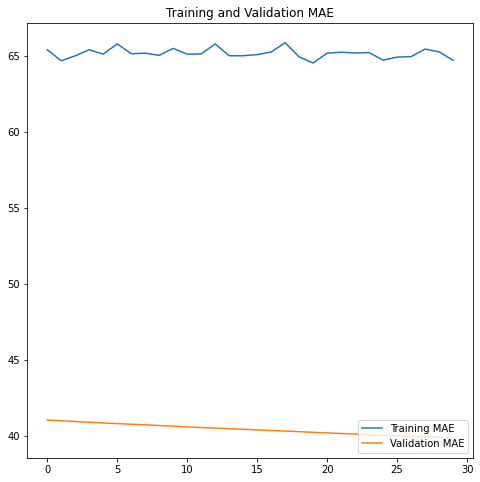

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history2.history['mae'], label='Training MAE')
plt.plot(history2.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

In [ ]:
checkpoint_filepath = './no_regul_finetune_best_model_add_epoch.h5'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    verbose=1
)

history2 = model2.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

model2.save('./by_chance_noregul_finetunemoed_plus.h5')

Epoch 1/30
159/159 [==============================] - ETA: 0s - loss: 65.1376 - mae: 65.1376
Epoch 1: val_mae improved from inf to 39.80605, saving model to ./no_regul_finetune_best_model_add_epoch.h5
159/159 [==============================] - 25s 160ms/step - loss: 65.1376 - mae: 65.1376 - val_loss: 39.8061 - val_mae: 39.8061
Epoch 2/30
159/159 [==============================] - ETA: 0s - loss: 64.6971 - mae: 64.6971
Epoch 2: val_mae improved from 39.80605 to 39.76365, saving model to ./no_regul_finetune_best_model_add_epoch.h5
159/159 [==============================] - 25s 160ms/step - loss: 64.6971 - mae: 64.6971 - val_loss: 39.7636 - val_mae: 39.7636
Epoch 3/30
159/159 [==============================] - ETA: 0s - loss: 64.9400 - mae: 64.9400
Epoch 3: val_mae improved from 39.76365 to 39.72429, saving model to ./no_regul_finetune_best_model_add_epoch.h5
159/159 [==============================] - 25s 160ms/step - loss: 64.9400 - mae: 64.9400 - val_loss: 39.7243 - val_mae: 39.7243
Epo

## learning rate 변경

In [ ]:
 base_model = efn.EfficientNetB4(
    weights='imagenet',
    include_top = False,
    input_shape = (IMAGE_SIZE,IMAGE_SIZE) + (3,)
)

In [ ]:

LEARNING_RATE = 1e-4

base_model.trainable = False
model3 = Sequential()
model3.add(base_model)
model3.add(GlobalAveragePooling2D()) # Flatten??
model3.add(Dropout(0.3))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(1, activation='linear'))

checkpoint_filepath = '/content/drive/MyDrive/AI_proj/no_regul_pretrain_best_model.h5'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    verbose=1
)

model3.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

In [ ]:
history3 = model3.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)


Epoch 1/30
159/159 [==============================] - ETA: 0s - loss: 79.6675 - mae: 79.6675
Epoch 1: val_mae improved from inf to 62.39625, saving model to /content/drive/MyDrive/AI_proj/no_regul_pretrain_best_model.h5
159/159 [==============================] - 45s 192ms/step - loss: 79.6675 - mae: 79.6675 - val_loss: 62.3963 - val_mae: 62.3963
Epoch 2/30
159/159 [==============================] - ETA: 0s - loss: 75.2488 - mae: 75.2488
Epoch 2: val_mae improved from 62.39625 to 58.41782, saving model to /content/drive/MyDrive/AI_proj/no_regul_pretrain_best_model.h5
159/159 [==============================] - 27s 168ms/step - loss: 75.2488 - mae: 75.2488 - val_loss: 58.4178 - val_mae: 58.4178
Epoch 3/30
159/159 [==============================] - ETA: 0s - loss: 73.4193 - mae: 73.4193
Epoch 3: val_mae improved from 58.41782 to 55.74139, saving model to /content/drive/MyDrive/AI_proj/no_regul_pretrain_best_model.h5
159/159 [==============================] - 27s 169ms/step - loss: 73.4193 

Text(0.5, 1.0, 'Training and Validation MAE')

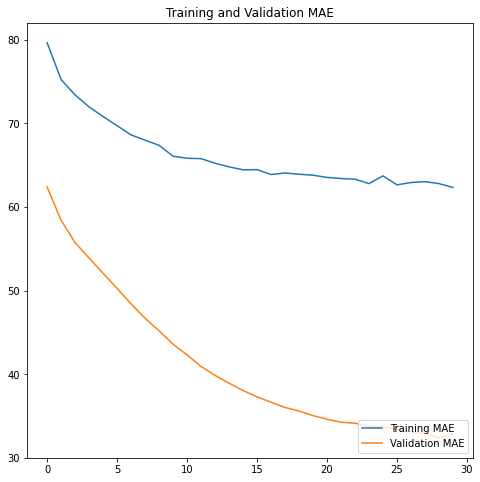

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history3.history['mae'], label='Training MAE')
plt.plot(history3.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

### finetune

In [ ]:
fine_tune_at= 400

for i, layer in enumerate(base_model.layers[:fine_tune_at]):
    if 'bn' not in layer.name :
        layer.trainable = True

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/AI_proj/no_regul_pretrain_best_model.h5'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    verbose=1
)

model3.compile(optimizer=Adam(learning_rate=LEARNING_RATE/10),
              loss='mae',
              metrics=['mae'])

history3 = model3.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/30
159/159 [==============================] - ETA: 0s - loss: 61.6685 - mae: 61.6685
Epoch 1: val_mae improved from inf to 32.81559, saving model to /content/drive/MyDrive/AI_proj/no_regul_pretrain_best_model.h5
159/159 [==============================] - 41s 188ms/step - loss: 61.6685 - mae: 61.6685 - val_loss: 32.8156 - val_mae: 32.8156
Epoch 2/30
159/159 [==============================] - ETA: 0s - loss: 62.5166 - mae: 62.5166
Epoch 2: val_mae improved from 32.81559 to 32.74851, saving model to /content/drive/MyDrive/AI_proj/no_regul_pretrain_best_model.h5
159/159 [==============================] - 27s 168ms/step - loss: 62.5166 - mae: 62.5166 - val_loss: 32.7485 - val_mae: 32.7485
Epoch 3/30
159/159 [==============================] - ETA: 0s - loss: 62.3190 - mae: 62.3190
Epoch 3: val_mae improved from 32.74851 to 32.70445, saving model to /content/drive/MyDrive/AI_proj/no_regul_pretrain_best_model.h5
159/159 [==============================] - 27s 168ms/step - loss: 62.3190 

Text(0.5, 1.0, 'Training and Validation MAE')

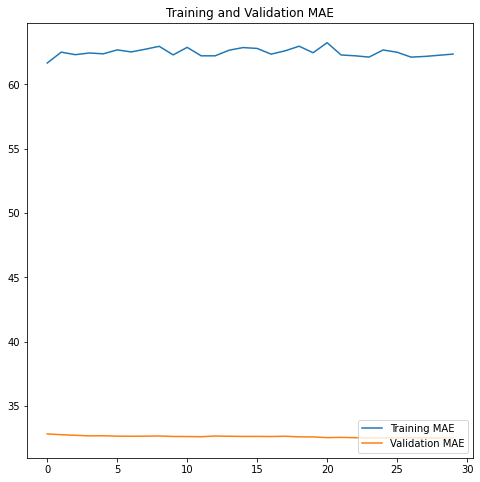

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history3.history['mae'], label='Training MAE')
plt.plot(history3.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

# Retry EfficientNet B4 fine tuning add augmentation

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB4

In [ ]:
IMAGE_SIZE = 256
LEARNING_RATE = 1e-4

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.3)
])

In [ ]:
preprocess_input= tf.keras.applications.efficientnet.preprocess_input
input_data = Input( shape = (None, None ,3) )
x = tf.keras.layers.RandomFlip('horizontal_and_vertical')(input_data)
x = tf.keras.layers.RandomRotation(0.3)(x)
x = preprocess_input(x)
preprocess = Model(inputs=input_data, outputs=x)

In [ ]:
base_model = efn.EfficientNetB4(
    weights='imagenet',
    include_top = False
)
base_model.trainable = False

In [ ]:
base_model.summary() # train prams => 0

In [ ]:
model = Sequential()
model.add(preprocess)
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, None, None, 3)     0         
                                                                 
 efficientnet-b4 (Functional  (None, None, None, 1792)  17673816 
 )                                                               
                                                                 
 global_average_pooling2d_1   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1792)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                114752    
                                                                 
 dense_4 (Dense)             (None, 64)               

학습

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/AI_proj/effb4/effb4.ckpt'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

NameError: ignored

### fine tuen

# Prediction

In [ ]:
len(test_img_path)

460

In [ ]:
PRED_BATCH_SIZE = 10

test set 생성

In [ ]:
test_dataset, file_names = create_test_dataset(test_img_path, (IMAGE_SIZE, IMAGE_SIZE), PRED_BATCH_SIZE )

  0%|          | 0/460 [00:00<?, ?it/s]

model load and predict

In [ ]:
eff_model = tf.keras.models.load_model('/content/drive/MyDrive/AI_proj/no_regul_pretrain_best_model.h5')

STEPS = len(test_img_path) / PRED_BATCH_SIZE
prediction = eff_model.predict(test_dataset,
                            batch_size = PRED_BATCH_SIZE,
                            steps=STEPS)


In [ ]:
prediction.shape

(460, 1)

In [ ]:
prediction

save to csv

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/AI_proj/data/sample_submission.csv')
submission['leaf_weight'] = prediction.squeeze()
submission.to_csv('/content/drive/MyDrive/AI_proj/data/effecientnet_cnn.csv', index=False)

# EfficientNetV2 L Model

In [ ]:
IMAGE_SIZE = 256,
EPOCHS = 30
LEARNING_RATE = 1e-4

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L

In [ ]:
preprocess_input= tf.keras.applications.efficientnet_v2.preprocess_input

In [ ]:
base_model = EfficientNetV2L(include_top = False,
                             weights='imagenet')

In [ ]:
input_data = Input( shape = (None, None ,3) )
x = preprocess_input(input_data)
preprocess = Model(inputs=input_data, outputs=x)

In [ ]:
model = Sequential()
model.add(preprocess)
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, None, None, 3)     0         
                                                                 
 efficientnetv2-l (Functiona  (None, None, None, 1280)  117746848
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_9 (Dense)             (None, 64)                81984     
                                                                 
 dense_10 (Dense)            (None, 64)               

In [ ]:
base_model.trainable = False

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/AI_proj/effv2L checkpoint/effv2L.ckpt'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, None, None, 3)     0         
                                                                 
 efficientnetv2-l (Functiona  (None, None, None, 1280)  117746848
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_9 (Dense)             (None, 64)                81984     
                                                                 
 dense_10 (Dense)            (None, 64)               

In [ ]:
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/30
159/159 [==============================] - ETA: 0s - loss: 79.0538 - mae: 79.0538
Epoch 1: val_mae improved from inf to 64.20319, saving model to /content/drive/MyDrive/AI_proj/effv2L checkpoint/effv2L.ckpt
159/159 [==============================] - 53s 236ms/step - loss: 79.0538 - mae: 79.0538 - val_loss: 64.2032 - val_mae: 64.2032
Epoch 2/30
159/159 [==============================] - ETA: 0s - loss: 76.9916 - mae: 76.9916
Epoch 2: val_mae improved from 64.20319 to 61.93242, saving model to /content/drive/MyDrive/AI_proj/effv2L checkpoint/effv2L.ckpt
159/159 [==============================] - 33s 205ms/step - loss: 76.9916 - mae: 76.9916 - val_loss: 61.9324 - val_mae: 61.9324
Epoch 3/30
159/159 [==============================] - ETA: 0s - loss: 75.6076 - mae: 75.6076
Epoch 3: val_mae improved from 61.93242 to 60.24652, saving model to /content/drive/MyDrive/AI_proj/effv2L checkpoint/effv2L.ckpt
159/159 [==============================] - 35s 218ms/step - loss: 75.6076 - mae:

Text(0.5, 1.0, 'Training and Validation MAE')

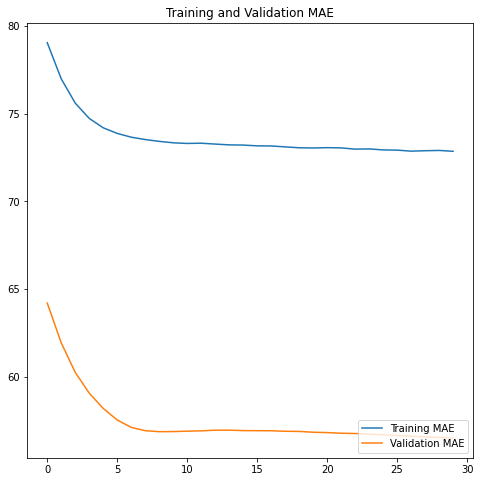

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

### Finetune

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  956


In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at= 800

# 동결 해제
for i, layer in enumerate(base_model.layers) :
    if i < fine_tune_at :
        layer.trainable = False
    else :
           if 'bn' in layer.name :
               layer.trainable = False

In [ ]:
model_filepath = '/content/drive/MyDrive/AI_proj/effiv2L_finetuned_best_model.h5'
checkpointer = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_mae',
    save_best_only=True,
    verbose=1
)

# transfer learning에서 최상의 weight을 불러옴.
model.load_weights(checkpoint_filepath)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE/10), # finetuning은 학습률을 낮게 설정.
              loss='mae',
              metrics=['mae'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, None, None, 3)     0         
                                                                 
 efficientnetv2-l (Functiona  (None, None, None, 1280)  117746848
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_9 (Dense)             (None, 64)                81984     
                                                                 
 dense_10 (Dense)            (None, 64)               

In [ ]:
history_fine = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/30
159/159 [==============================] - ETA: 0s - loss: 75.5649 - mae: 75.5649
Epoch 1: val_mae improved from inf to 49.43916, saving model to /content/drive/MyDrive/AI_proj/effiv2L_finetuned_best_model.h5
159/159 [==============================] - 67s 313ms/step - loss: 75.5649 - mae: 75.5649 - val_loss: 49.4392 - val_mae: 49.4392
Epoch 2/30
159/159 [==============================] - ETA: 0s - loss: 71.1457 - mae: 71.1457
Epoch 2: val_mae improved from 49.43916 to 44.77898, saving model to /content/drive/MyDrive/AI_proj/effiv2L_finetuned_best_model.h5
159/159 [==============================] - 55s 345ms/step - loss: 71.1457 - mae: 71.1457 - val_loss: 44.7790 - val_mae: 44.7790
Epoch 3/30
159/159 [==============================] - ETA: 0s - loss: 69.9551 - mae: 69.9551
Epoch 3: val_mae improved from 44.77898 to 43.17474, saving model to /content/drive/MyDrive/AI_proj/effiv2L_finetuned_best_model.h5
159/159 [==============================] - 58s 366ms/step - loss: 69.9551 

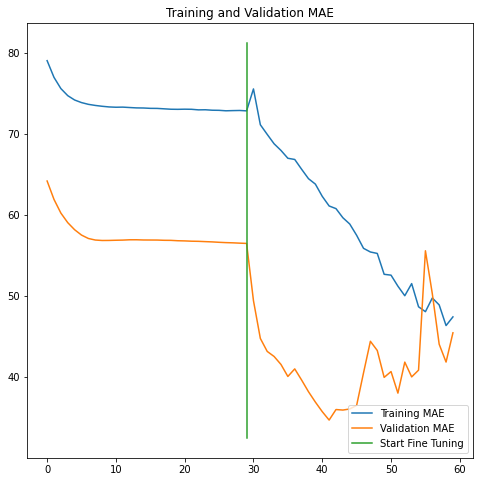

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae']+history_fine.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae']+history_fine.history['val_mae'], label='Validation MAE')
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')
plt.show()

### prediction

In [ ]:
eff_model = tf.keras.models.load_model(model_filepath)

STEPS = len(test_img_path) / PRED_BATCH_SIZE
prediction = eff_model.predict(test_dataset,
                            batch_size = PRED_BATCH_SIZE,
                            steps=STEPS)

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/AI_proj/data/sample_submission.csv')
submission['leaf_weight'] = prediction.squeeze()
submission.to_csv('/content/drive/MyDrive/AI_proj/data/effecientnetV2L_cnn.csv', index=False)